# 0) Work Directory and setup

In [1]:
import os
# Obtiene el nuevo directorio actual después del cambio
new_directory = '/Users/jyoung/Doctorado/embryo_classification/'
os.chdir(new_directory)
print("New actual directory:", new_directory)

# Elimino warnings molestas
import warnings
warnings.filterwarnings("ignore")


New actual directory: /Users/jyoung/Doctorado/embryo_classification/


# 1) Libraries

In [2]:
# Data Manipulation and Visualization
import numpy as np  # NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Matplotlib for creating visualizations
from pathlib import Path  # Pathlib for working with file paths
import openpyxl  # Openpyxl for reading and writing Excel files
import json  # JSON for data serialization
from tqdm import tqdm  # tqdm for creating progress bars
from typing import Tuple, List, Union  # Typing for type hinting in function signatures

# Model Training and Evaluation
import torch  # PyTorch for tensor computations and neural network support
import torch.nn.functional as F  # Functions without parameters for neural network operations
import torchvision.transforms as T  # Image transformations and utilities for PyTorch
from torch.utils.data import Dataset  # Base class for creating custom datasets in PyTorch
import torch.nn as nn  # Neural network modules and classes to build networks
import torch.optim as optim  # Optimization algorithms in PyTorch
import torchvision.models as models  # Pretrained models and architectures in PyTorch
from sklearn.model_selection import train_test_split  # Split datasets for training and validation
import torch.optim as optim  # Optimization algorithms in PyTorch (repeated import)
from torch.utils.data import DataLoader  # Data loading utilities for PyTorch models
from torch.cuda.amp import autocast  # Automatic mixed precision training in PyTorch
from sklearn.model_selection import KFold  # K-Folds cross-validator for model evaluation


# Image Processing and Feature Extraction
from skimage import exposure  # Image exposure adjustment
from scipy import ndimage  # Multi-dimensional image processing
import skimage.measure  # Image measurement and analysis
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # Image preprocessing using Keras
from PIL import Image  # Python Imaging Library for image processing

# Signal Processing
from scipy.signal import find_peaks, savgol_filter  # Signal processing functions in SciPy
import cv2  # OpenCV for computer vision tasks


2023-11-25 20:54:43.545581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2) Functions

## Image functions

In [3]:
def load_image(region: str, index: int) -> np.ndarray:
    """
    Loads and preprocesses an image from a specified region and index.

    Parameters:
    - region (str): Name of the region.
    - index (int): Index of the image.

    Returns:
    - chosen_region (np.ndarray): Preprocessed image.
    """
    chosen_region = img_to_array(load_img(str(region) + '/' + str(index) + '.bmp', grayscale=True)).squeeze() / 255.0
    return chosen_region


def plot_sample_image(index: int, dataset : Dataset) -> None:
    """
    Plots a sample image and its label from the dataset.

    Args:
    - index (int): Index of the image in the dataset to be plotted.
    - dataset: The dataset object containing the images and labels.

    Returns:
    - None
    """
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 2))

    for i in range(3):
        imagen, label = dataset.__getitem__(index)
        imagen = np.swapaxes(imagen, 0, 2)
        label = convert_to_text(label)
        axes[i].imshow(imagen)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


## Training functions

In [11]:
def train_one_epoch(model : torch.nn.Module,
                    optimizer : torch.optim.Optimizer,
                    data_loader : torch.utils.data.DataLoader,
                    device : str,
                    dtype : type = torch.float32,
                    scaler : torch.cuda.amp.GradScaler = None ) -> Tuple[float, float]:
    """
    Trains the model for one epoch using the provided data_loader.

    Args:
    - model: The neural network model to be trained.
    - optimizer: The optimizer used for training the model.
    - data_loader: The data loader providing training data.
    - device: The device on which the training will be performed (e.g., 'cpu' or 'cuda').
    - dtype (torch.dtype, optional): The data type used for the tensors (default: torch.float32).
    - scaler (torch.cuda.amp.GradScaler, optional): Gradient scaler for mixed precision training (default: None).

    Returns:
    - tuple: A tuple containing the average loss per sample and the accuracy for the epoch.
    """
    model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device=device, dtype=dtype), y.to(device=device, dtype=torch.long)
        optimizer.zero_grad()
        with autocast(enabled=(scaler is not None)):
            scores = model(x)
            loss = F.cross_entropy(scores, y)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * x.size(0)
        _, predicted = scores.max(1)
        correct += (predicted == y).sum().item()
        total_samples += x.size(0)

    return total_loss / total_samples, correct / total_samples


def accuracy(loader: torch.utils.data.DataLoader,
            model : torch.nn.Module,
            device : str,
            dtype : type = torch.float32) -> float:
    """
    Calculates accuracy on a given data loader using the provided model.

    Args:
    - loader: The data loader to calculate accuracy on.
    - model: The neural network model to evaluate.
    - device: The device on which the evaluation will be performed (e.g., 'cpu' or 'cuda').
    - dtype (torch.dtype, optional): The data type used for the tensors (default: torch.float32).

    Returns:
    - float: The accuracy of the model on the given data loader.
    """
    print(f'Checking accuracy')

    model.eval()
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device=device, dtype=dtype), y.to(device=device, dtype=torch.long)

            scores = model(x)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum().item()
            num_samples += preds.size(0)
        
        accuracy = num_correct / num_samples if num_samples > 0 else 0
        print(f'Got {num_correct} / {num_samples} correct ({100 * accuracy:.2f}%)')
    
    return accuracy


def get_pretrained_model(model_name: str) -> torch.nn.Module:
    """
    Loads a pre-trained model based on the specified model name.

    Args:
    - model_name (str): The name of the pre-trained model ('vgg16', 'resnet50', 'inceptionv3', or 'mobilenetv2').

    Returns:
    - torch.nn.Module: The pre-trained model specified by the model_name.
    """
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
    elif model_name == 'inceptionv3':
        model = models.inception_v3(pretrained=True)
    else:
        raise ValueError('Model not recognized. Choose from vgg16, resnet50, inceptionv3, or mobilenetv2')
    
    return model




## Dataset functions

In [5]:
import os  # Importing the 'os' library to handle operating system functionalities

class EmbryoDataset(Dataset):
    def __init__(self, img_dir, labels):
        self.img_labels = labels  # Store the image labels
        self.img_dir = img_dir  # Store the directory containing the images

        # Define a series of image transformations using torchvision's Compose
        self.transform = T.Compose([
            T.Pad(100, padding_mode='reflect'),  # Padding the images
            T.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a 50% probability
            T.RandomRotation(degrees=(-10, 10), fill=100),  # Randomly rotate the image between -10 and 10 degrees
            T.Resize((400, 400)),  # Resize the image to (400, 400)
            T.CenterCrop(300),  # Center crop the resized image to a final size of (300, 300)
            T.ToTensor()  # Convert the image to a PyTorch tensor
        ])

    def __len__(self):
        return len(self.img_labels)  # Return the total number of images in the dataset

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(idx + 1) + '.BMP')  # Construct the path for each image
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read the image using OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB format
        label = int(self.img_labels[idx])  # Retrieve the label for the corresponding image

        if self.transform:
            image = Image.fromarray(image)  # Convert the image to a PIL Image
            image = self.transform(image)  # Apply the defined transformations to the image

        return image, label  # Return the transformed image and its label


## Utility functions

In [6]:
def convert_to_number(x : str) -> int:
    """
    Converts a label to its corresponding numeric value.

    Parameters:
    - x (str): Input label.

    Returns:
    - int: Numeric value corresponding to the input label.
    """
    if x == 'A':
        return 0
    if x == 'B':
        return 1
    if x == 'C':
        return 2
    
def convert_to_text(numeric_value : int) -> str:
    """
    Converts a numeric value to its corresponding label.

    Parameters:
    - numeric_value (int): Input numeric value.

    Returns:
    - str: Label corresponding to the input numeric value.
    """
    if numeric_value == 0:
        return 'A'
    if numeric_value == 1:
        return 'B'
    if numeric_value == 2:
        return 'C'

    
def choose_region(zone: str, n_data: int, blast_quality: list) -> list:
    """
    Extracts labels for a specific zone (ICM, TE, or ZP) from the given blast_quality.

    Args:
    - zone (str): The zone for which labels need to be extracted ('ICM', 'TE', or 'ZP').
    - n_data (int): The number of data points.
    - blast_quality (list): List containing blast quality data.

    Returns:
    - numpy.ndarray: An array containing labels for the specified zone.
    """
    y_ICM = np.zeros(n_data - 1)
    y_TE = np.zeros(n_data - 1)
    y_ZP = np.zeros(n_data - 1)

    for i in np.arange(1, n_data):
        y_ICM[i - 1] = convert_to_number(blast_quality[i - 1][1])
        y_TE[i - 1] = convert_to_number(blast_quality[i - 1][2])
        y_ZP[i - 1] = convert_to_number(blast_quality[i - 1][0])

    if zone == 'ICM':
        y_data = y_ICM
    elif zone == 'TE':
        y_data = y_TE
    elif zone == 'ZP':
        y_data = y_ZP
    else:
        raise ValueError("Invalid zone. Zone must be 'ICM', 'TE', or 'ZP'.")

    return y_data

    

# 3) Load dataset

## Load labels

In [7]:
n_data = 250  # Total number of data points
region = 'ICM'  # Selected region
xlsx_file = Path('data/BlastsOnline', 'MasterlistAug30-2017.xlsx')  # Path to the Excel file
wb_obj = openpyxl.load_workbook(xlsx_file)  # Loading the Excel workbook

sheet = wb_obj.active  # Selecting the active sheet from the workbook

blast_quality = []  # List to store quality values for blast
# Loop through the sheet and extract quality values for each data point
for i in range(2, n_data + 1):
    blast_quality.append(list(sheet['B' + str(i)].value))

# Choosing the region for the data by calling the function choose_region
y = choose_region(region, n_data, blast_quality)


## Build dataset

In [8]:
img_dir = 'data/BlastsOnline/Images'  # Directory containing image data

# Creating an instance of EmbryoDataset for the selected region
EmbryoDataset = EmbryoDataset(img_dir, y)

# 4) Plot samples

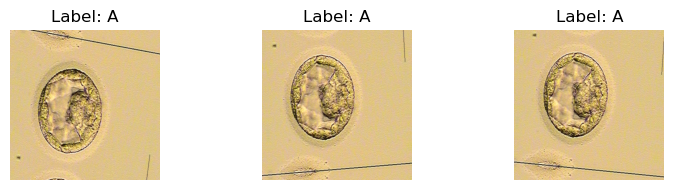

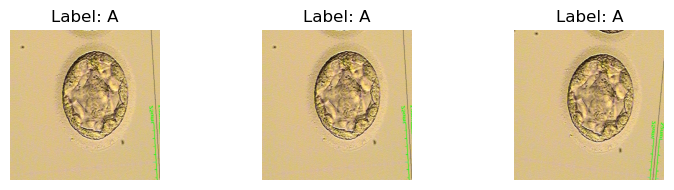

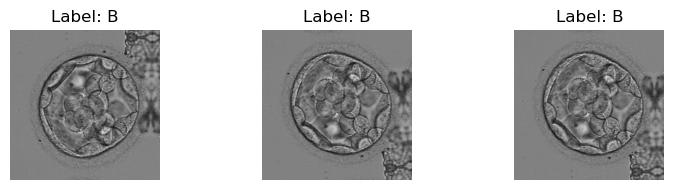

In [9]:
plot_sample_image(0, EmbryoDataset)  # Plotting a sample image at index 0 from the EmbryoDataset
plot_sample_image(1, EmbryoDataset)  # Plotting a sample image at index 1 from the EmbryoDataset
plot_sample_image(2, EmbryoDataset)  # Plotting a sample image at index 2 from the EmbryoDataset


# 5) Entrenamiento

## Training setup

In [12]:

# Define el número de pliegues para la validación cruzada
num_folds = 10  # Por ejemplo, utiliza 10-fold cross-validation
num_folds = 2  # O 2 para ir más rápido en la prueba

# Definición de otros hiperparámetros
learning_rate = 0.001
batch_size = 16
num_epochs = 2

# Crea un objeto KFold para dividir tus datos
kf = KFold(n_splits=num_folds, shuffle=True)

# Creación del modelo elegido
model_name = 'vgg16'  # Aquí elige el modelo que quieras utilizar
model = get_pretrained_model(model_name)

# Resto del código para el entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Seleccionar el optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loop sobre los pliegues (folds)
for fold, (train_index, val_index) in enumerate(kf.split(EmbryoDataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Divide los datos en conjunto de entrenamiento y validación para este pliegue
    train_dataset = torch.utils.data.Subset(EmbryoDataset, train_index)
    valid_dataset = torch.utils.data.Subset(EmbryoDataset, val_index)

    # Crea los DataLoaders para este pliegue
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valid_dataset, batch_size=batch_size)

    train_loss, train_acc = train_one_epoch(model, optimizer, train_loader, device)
    print(f"Epoch [{fold + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    val_acc = accuracy(val_loader, model, device)
    print(f"Epoch [{fold + 1}/{num_epochs}], Validation Acc: {val_acc:.4f}")


Fold 1/2


100%|██████████| 8/8 [02:29<00:00, 18.75s/it]


Epoch [1/2], Train Loss: 18.7834, Train Acc: 0.4113
Checking accuracy
Got 85 / 125 correct (68.00%)
Epoch [1/2], Validation Acc: 0.6800
Fold 2/2


100%|██████████| 8/8 [02:33<00:00, 19.23s/it]


Epoch [2/2], Train Loss: 1.6780, Train Acc: 0.6240
Checking accuracy
Got 82 / 124 correct (66.13%)
Epoch [2/2], Validation Acc: 0.6613
